# MID_TERMS_PROJECT / MID_TERMS_EXAMEN

**<center> Goal:</center>**
The goal of this competition is to predict MDS-UPDR scores, which measure progression in patients with Parkinson's disease. The Movement Disorder Society-Sponsored Revision of the Unified Parkinson's Disease Rating Scale (MDS-UPDRS) is a comprehensive assessment of both motor and non-motor symptoms associated with Parkinson's. You will develop a model trained on data of protein and peptide levels over time in subjects with Parkinson’s disease versus normal age-matched control subjects.

Your work could help provide important breakthrough information about which molecules change as Parkinson’s disease progresses.

Source : https://www.kaggle.com/competitions/amp-parkinsons-disease-progression-prediction/overview

Documentation for the Model Keras : https://www.tensorflow.org/guide/keras/sequential_model?hl=fr

Documentation Loss Function : https://keras.io/api/losses/

*CV means Cross Validation. This is the score in your validation set. In a competition, the LB normally is computed only 20-30 % test data. Everyday you submit to get a high score in the LB, even your CV is not good. It makes your model overfits with 20-30 % which is used for the LB.*

# Import data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers

train_clinical_data = pd.read_csv("../Mid_term_project/train_clinical_data.csv")
train_peptides_data = pd.read_csv("../Mid_term_project/train_peptides.csv")
train_protiens_data = pd.read_csv("../Mid_term_project/train_proteins.csv")
supplemental_clinical_data = pd.read_csv("../Mid_term_project/supplemental_clinical_data.csv")

In [2]:
train_clinical_data

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On
...,...,...,...,...,...,...,...,...
2610,65043_48,65043,48,7.0,6.0,13.0,0.0,Off
2611,65043_54,65043,54,4.0,8.0,11.0,1.0,Off
2612,65043_60,65043,60,6.0,6.0,16.0,1.0,Off
2613,65043_72,65043,72,3.0,9.0,14.0,1.0,Off


In [3]:
print("Found {:,d} unique patient_id values".format(train_clinical_data["patient_id"].nunique()))
print("Found {:,d} unique visit_month values".format(train_clinical_data["visit_month"].nunique()))

Found 248 unique patient_id values
Found 17 unique visit_month values


In [4]:
train_peptides_data

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.30
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.00
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.00
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.90
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.70
...,...,...,...,...,...,...
981829,58648_108,108,58648,Q9UHG2,ILAGSADSEGVAAPR,202820.00
981830,58648_108,108,58648,Q9UKV8,SGNIPAGTTVDTK,105830.00
981831,58648_108,108,58648,Q9Y646,LALLVDTVGPR,21257.60
981832,58648_108,108,58648,Q9Y6R7,AGC(UniMod_4)VAESTAVC(UniMod_4)R,5127.26


In [ ]:
print("Found {:,d} unique patient_id values".format(train_peptides_data["patient_id"].nunique()))
print("Found {:,d} unique visit_month values".format(train_peptides_data["visit_month"].nunique()))
print("Found {:,d} unique peptide values".format(train_peptides_data["Peptide"].nunique()))
print("Found {:,d} unique UniProt values".format(train_peptides_data["UniProt"].nunique()))

In [5]:
train_protiens_data

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0
...,...,...,...,...,...
232736,58648_108,108,58648,Q9UBX5,27387.8
232737,58648_108,108,58648,Q9UHG2,369437.0
232738,58648_108,108,58648,Q9UKV8,105830.0
232739,58648_108,108,58648,Q9Y646,21257.6


In [ ]:
print("Found {:,d} unique patient_id values".format(train_protiens_data["patient_id"].nunique()))
print("Found {:,d} unique visit_month values".format(train_protiens_data["visit_month"].nunique()))
print("Found {:,d} unique UniProt values".format(train_protiens_data["UniProt"].nunique()))

In [ ]:
supplemental_clinical_data

In [ ]:
print("Found {:,d} unique patient_id values".format(supplemental_clinical_data["patient_id"].nunique()))
print("Found {:,d} unique visit_month values".format(supplemental_clinical_data["visit_month"].nunique()))

**<center> Observations : </center>**
 
**1. Train_clinical_data :**

We have here 248 unique patients with each a certain degree of disease according to the updrs_[1-4].
 
 updrs_[1-4] - The patient's score for part N of the Unified Parkinson's Disease Rating Scale. Higher numbers indicate more severe symptoms. Each sub-section covers a distinct category of symptoms, such as mood and behavior for Part 1 and motor functions for Part 3.

* Found 248 unique patient_id values
* Found 17 unique visit_month values
 
**2. Train_peptides_data :**

UniProt - The UniProt ID code for the associated protein. There are often several peptides per protein.
Peptide - The sequence of amino acids included in the peptide. Some rare annotations may not be included in the table. The test set may include peptides not found in the train set.

* Found 248 unique patient_id values
* Found 968 unique peptide values
* Found 227 unique UniProt values

**3. Train_protiens_data :**

* Found 248 unique patient_id values
* Found 227 unique UniProt values

**4. Dupplemental_clinical_data :**

There is no protein records. We can use this data to observe patient taking a PD (Parkinson's disease) medicine and the degree of disease updrs_[1-4].

* Found 771 unique patient_id values
* Found 8 unique visit_month values

# Visualization of data

In [ ]:
# Counting the number of NaN in the train_clinial_data

null_count = train_clinical_data.isna().sum().to_list()
plt.bar(list(train_clinical_data),null_count)
plt.xticks(list(train_clinical_data), rotation=90)

In [ ]:
# Counting the number of NaN in the train_peptides_data

null_count_1 = train_peptides_data.isna().sum().to_list()
print(null_count_1)

In [ ]:
# Counting the number of NaN in the train_protiens_data

null_count_2 = train_protiens_data.isna().sum().to_list()
print(null_count_2)

In [ ]:
# Counting the number of NaN in the supplemental_clinical_data

null_count_3 = supplemental_clinical_data.isna().sum().to_list()
plt.bar(list(supplemental_clinical_data),null_count_3)
plt.xticks(list(supplemental_clinical_data), rotation=90)

**<center> Observations 1 : </center>**

We can see that the train_peptides_data and train_protein_data have no NAN value which is great. 

However, we have a lot of rows from train_clinical_data with NAN value  : 1327 upd23b_clinical_state_on_medication / 2615 rows = 0.507, half of the rows have NAN value.

However, we have a lot of rows from supplemental_clinical_data with NAN value  : 1101 upd23b_clinical_state_on_medication / 2223 rows = 0.495, half of the rows have NAN value.

One solution of this problem is : replace the NaN value by the previous value

**Now, I'm going to concat the 2 dataset from clinical and supplemental_clinical and see how the updrs is evolving over the months and remove the NaN values**



In [ ]:
concat_data = pd.concat([train_clinical_data, supplemental_clinical_data]).dropna()
concat_data

In [ ]:
print("Found {:,d} unique patient_id values".format(concat_data["patient_id"].nunique()))
print("Found {:,d} unique vist_month values".format(concat_data["visit_month"].nunique()))

**How are Updrs evolved over months for the concatenation data with considereing is medication on or off?**

Sort data over months and plot the mean of Updrs from all patient.

Medication on and off data were taken.

In [ ]:
clinical_data = concat_data.sort_values(by = ['visit_month'])   

visit_month = clinical_data["visit_month"].tolist()

updrs_1 = clinical_data["updrs_1"].tolist()
updrs_2 = clinical_data["updrs_2"].tolist()
updrs_3 = clinical_data["updrs_3"].tolist()
updrs_4 = clinical_data["updrs_4"].tolist()
res = {}
mois = []
mean_updrs_1 = []
mean_updrs_2 = []
mean_updrs_3 = []
mean_updrs_4 = []

ancienne_position = 0

for i in visit_month:
    res[i] = visit_month.count(i)
for i in res:
    mois.append(i)

for i in res:
    sum = 0
    for j in range(res[i]):
        sum = updrs_1[j + ancienne_position] + sum
    ancienne_position = res[i]
    mean_updrs_1.append(sum/res[i])

for i in res:
    sum = 0
    for j in range(res[i]):
        sum = updrs_2[j + ancienne_position] + sum
    ancienne_position = res[i]
    mean_updrs_2.append(sum/res[i])

for i in res:
    sum = 0
    for j in range(res[i]):
        sum = updrs_3[j + ancienne_position] + sum
    ancienne_position = res[i]
    mean_updrs_3.append(sum/res[i])

for i in res:
    sum = 0
    for j in range(res[i]):
        sum = updrs_4[j + ancienne_position] + sum
    ancienne_position = res[i]
    mean_updrs_4.append(sum/res[i])

print("Months:",mois)

figure, axis = plt.subplots(2, 2)

axis[0, 0].scatter(mois, mean_updrs_1)
axis[0, 0].set_title("mean_updrs_1 over months")
  

axis[0, 1].scatter(mois, mean_updrs_2)
axis[0, 1].set_title("mean_updrs_2 over months")
  

axis[1, 0].scatter(mois, mean_updrs_3)
axis[1, 0].set_title("mean_updrs_3 over months")

axis[1, 1].scatter(mois, mean_updrs_4)
axis[1, 1].set_title("mean_updrs_4 over months")
  
figure.tight_layout(pad=2.5)
plt.show()

figure1, axis1 = plt.subplots(2, 2)

axis1[0, 0].plot(mois, mean_updrs_1)
axis1[0, 0].set_title("mean_updrs_1 over months")
  

axis1[0, 1].plot(mois, mean_updrs_2)
axis1[0, 1].set_title("mean_updrs_2 over months")
  

axis1[1, 0].plot(mois, mean_updrs_3)
axis1[1, 0].set_title("mean_updrs_3 over months")

axis1[1, 1].plot(mois, mean_updrs_4)
axis1[1, 1].set_title("mean_updrs_4 over months")
  
figure1.tight_layout(pad=2.5)
plt.show()

Sort data over months and plot the mean of Updrs from all patient.

Only Medication off data were taken.

In [ ]:
clinical_data = concat_data.sort_values(by = ["visit_month"])   

visit_month_off = clinical_data[clinical_data["upd23b_clinical_state_on_medication"]=="Off"]["visit_month"].tolist()

updrs_1_off = clinical_data[clinical_data["upd23b_clinical_state_on_medication"]=="Off"]["updrs_1"].tolist()
updrs_2_off = clinical_data[clinical_data["upd23b_clinical_state_on_medication"]=="Off"]["updrs_2"].tolist()
updrs_3_off = clinical_data[clinical_data["upd23b_clinical_state_on_medication"]=="Off"]["updrs_3"].tolist()
updrs_4_off = clinical_data[clinical_data["upd23b_clinical_state_on_medication"]=="Off"]["updrs_4"].tolist()
res = {}
mois = []
mean_updrs_1_off = []
mean_updrs_2_off = []
mean_updrs_3_off = []
mean_updrs_4_off = []

ancienne_position = 0

for i in visit_month_off:
    res[i] = visit_month_off.count(i)
for i in res:
    mois.append(i)

for i in res:
    sum = 0
    for j in range(res[i]):
        sum = updrs_1_off[j + ancienne_position] + sum
    ancienne_position = res[i]
    mean_updrs_1_off.append(sum/res[i])

for i in res:
    sum = 0
    for j in range(res[i]):
        sum = updrs_2_off[j + ancienne_position] + sum
    ancienne_position = res[i]
    mean_updrs_2_off.append(sum/res[i])

for i in res:
    sum = 0
    for j in range(res[i]):
        sum = updrs_3_off[j + ancienne_position] + sum
    ancienne_position = res[i]
    mean_updrs_3_off.append(sum/res[i])

for i in res:
    sum = 0
    for j in range(res[i]):
        sum = updrs_4_off[j + ancienne_position] + sum
    ancienne_position = res[i]
    mean_updrs_4_off.append(sum/res[i])

print("Months:",mois)

figure, axis = plt.subplots(2, 2)

axis[0, 0].scatter(mois, mean_updrs_1_off)
axis[0, 0].set_title("mean_updrs_1_off over months")
  

axis[0, 1].scatter(mois, mean_updrs_2_off)
axis[0, 1].set_title("mean_updrs_2_off over months")
  

axis[1, 0].scatter(mois, mean_updrs_3_off)
axis[1, 0].set_title("mean_updrs_3_off over months")

axis[1, 1].scatter(mois, mean_updrs_4_off)
axis[1, 1].set_title("mean_updrs_4_off over months")
  
figure.tight_layout(pad=2.5)
plt.show()

figure1, axis1 = plt.subplots(2, 2)

axis1[0, 0].plot(mois, mean_updrs_1_off)
axis1[0, 0].set_title("mean_updrs_1_off over months")
  

axis1[0, 1].plot(mois, mean_updrs_2_off)
axis1[0, 1].set_title("mean_updrs_2_off over months")
  

axis1[1, 0].plot(mois, mean_updrs_3_off)
axis1[1, 0].set_title("mean_updrs_3_off over months")

axis1[1, 1].plot(mois, mean_updrs_4_off)
axis1[1, 1].set_title("mean_updrs_4_off over months")
  
figure1.tight_layout(pad=2.5)
plt.show()


Sort data over months and plot the mean of Updrs from all patient.

Only Medication on data were taken.

In [ ]:
clinical_data = concat_data.sort_values(by = ["visit_month"])   

visit_month_on = clinical_data[clinical_data["upd23b_clinical_state_on_medication"]=="On"]["visit_month"].tolist()

updrs_1_on = clinical_data[clinical_data["upd23b_clinical_state_on_medication"]=="On"]["updrs_1"].tolist()
updrs_2_on = clinical_data[clinical_data["upd23b_clinical_state_on_medication"]=="On"]["updrs_2"].tolist()
updrs_3_on = clinical_data[clinical_data["upd23b_clinical_state_on_medication"]=="On"]["updrs_3"].tolist()
updrs_4_on = clinical_data[clinical_data["upd23b_clinical_state_on_medication"]=="On"]["updrs_4"].tolist()
res = {}
mois = []
mean_updrs_1_on = []
mean_updrs_2_on = []
mean_updrs_3_on = []
mean_updrs_4_on = []

ancienne_position = 0

for i in visit_month_on:
    res[i] = visit_month_on.count(i)
for i in res:
    mois.append(i)

for i in res:
    sum = 0
    for j in range(res[i]):
        sum = updrs_1_on[j + ancienne_position] + sum
    ancienne_position = res[i]
    mean_updrs_1_on.append(sum/res[i])

for i in res:
    sum = 0
    for j in range(res[i]):
        sum = updrs_2_on[j + ancienne_position] + sum
    ancienne_position = res[i]
    mean_updrs_2_on.append(sum/res[i])

for i in res:
    sum = 0
    for j in range(res[i]):
        sum = updrs_3_on[j + ancienne_position] + sum
    ancienne_position = res[i]
    mean_updrs_3_on.append(sum/res[i])

for i in res:
    sum = 0
    for j in range(res[i]):
        sum = updrs_4_on[j + ancienne_position] + sum
    ancienne_position = res[i]
    mean_updrs_4_on.append(sum/res[i])

print("Months:",mois)

figure, axis = plt.subplots(2, 2)

axis[0, 0].scatter(mois, mean_updrs_1_on)
axis[0, 0].set_title("mean_updrs_1_on over months")
  

axis[0, 1].scatter(mois, mean_updrs_2_on)
axis[0, 1].set_title("mean_updrs_2_on over months")
  

axis[1, 0].scatter(mois, mean_updrs_3_on)
axis[1, 0].set_title("mean_updrs_3_on over months")

axis[1, 1].scatter(mois, mean_updrs_4_on)
axis[1, 1].set_title("mean_updrs_4_on over months")
  
figure.tight_layout(pad=2.5)
plt.show()

figure1, axis1 = plt.subplots(2, 2)

axis1[0, 0].plot(mois, mean_updrs_1_on)
axis1[0, 0].set_title("mean_updrs_1_on over months")
  

axis1[0, 1].plot(mois, mean_updrs_2_on)
axis1[0, 1].set_title("mean_updrs_2_on over months")
  

axis1[1, 0].plot(mois, mean_updrs_3_on)
axis1[1, 0].set_title("mean_updrs_3_on over months")

axis1[1, 1].plot(mois, mean_updrs_4_on)
axis1[1, 1].set_title("mean_updrs_4_on over months")
  
figure1.tight_layout(pad=2.5)
plt.show()

**<center> Observations 2 : </center>**

If the medicine is off, the updrs[1_4] are constant of the months.

If the medicine is on, the updrs[1_4] are slowed by the medicine, we can see an increase around the 75th month.

In general, the updr[1_4] are increasing over the month, with or not the medicine.

We can maybe think about a regression to predict the value of the updrs[1_4].

# Re-arrange the data : Merging the percentage of protein and the updrs

In [6]:
# Let's dive into deep, and firstly I drop the state on medication and patient_id because I cant handle every parameters for nox.

train = train_clinical_data.drop(["upd23b_clinical_state_on_medication", "patient_id"],axis=1)
train

,visit_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,55_0,0,10.0,6.0,15.0,NaN
1,55_3,3,10.0,7.0,25.0,NaN
2,55_6,6,8.0,10.0,34.0,NaN
3,55_9,9,8.0,9.0,30.0,0.0
4,55_12,12,10.0,10.0,41.0,0.0
...,...,...,...,...,...,...
2610,65043_48,48,7.0,6.0,13.0,0.0
2611,65043_54,54,4.0,8.0,11.0,1.0
2612,65043_60,60,6.0,6.0,16.0,1.0
2613,65043_72,72,3.0,9.0,14.0,1.0


In [8]:
# Let's merge the train_protiens and train_peptides data.

pep_pro = pd.merge(train_protiens_data, train_peptides_data, on=['visit_id', 'visit_month', 'patient_id', 'UniProt'])
print("Found {:,d} unique patient_id values".format(pep_pro["patient_id"].nunique()))
print("Found {:,d} unique vist_month values".format(pep_pro["visit_month"].nunique()))

Found 248 unique patient_id values
Found 15 unique vist_month values


In [9]:
# I calculate Percentage_of_pep_in_Uniprot 
# The Peptide = sequence of amino acids 
# When the sequence of amino acids is more than 10 the name become protein and protein contains more than on peptide...
pep_pro["Percentage_of_pep_in_Uniprot"] = pep_pro["PeptideAbundance"] / pep_pro["NPX"]
pep_pro

,visit_id,visit_month,patient_id,UniProt,NPX,Peptide,PeptideAbundance,Percentage_of_pep_in_Uniprot
0,55_0,0,55,O00391,11254.3,NEQEQPLGQWHLS,11254.30,1.000000
1,55_0,0,55,O00533,732430.0,GNPEPTFSWTK,102060.00,0.139344
2,55_0,0,55,O00533,732430.0,IEIPSSVQQVPTIIK,174185.00,0.237818
3,55_0,0,55,O00533,732430.0,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.90,0.037244
4,55_0,0,55,O00533,732430.0,SMEQNGPGLEYR,30838.70,0.042105
...,...,...,...,...,...,...,...,...
981829,58648_108,108,58648,Q9UHG2,369437.0,ILAGSADSEGVAAPR,202820.00,0.548998
981830,58648_108,108,58648,Q9UKV8,105830.0,SGNIPAGTTVDTK,105830.00,1.000000
981831,58648_108,108,58648,Q9Y646,21257.6,LALLVDTVGPR,21257.60,1.000000
981832,58648_108,108,58648,Q9Y6R7,17953.1,AGC(UniMod_4)VAESTAVC(UniMod_4)R,5127.26,0.285592


For example : ![image](Midterm_image.PNG)

In [10]:
#Dropping the patient_id and visith_month because I will re-integer them later.

pep_pro = pep_pro.drop(["patient_id","visit_month"], axis=1)
pep_pro

,visit_id,UniProt,NPX,Peptide,PeptideAbundance,Percentage_of_pep_in_Uniprot
0,55_0,O00391,11254.3,NEQEQPLGQWHLS,11254.30,1.000000
1,55_0,O00533,732430.0,GNPEPTFSWTK,102060.00,0.139344
2,55_0,O00533,732430.0,IEIPSSVQQVPTIIK,174185.00,0.237818
3,55_0,O00533,732430.0,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.90,0.037244
4,55_0,O00533,732430.0,SMEQNGPGLEYR,30838.70,0.042105
...,...,...,...,...,...,...
981829,58648_108,Q9UHG2,369437.0,ILAGSADSEGVAAPR,202820.00,0.548998
981830,58648_108,Q9UKV8,105830.0,SGNIPAGTTVDTK,105830.00,1.000000
981831,58648_108,Q9Y646,21257.6,LALLVDTVGPR,21257.60,1.000000
981832,58648_108,Q9Y6R7,17953.1,AGC(UniMod_4)VAESTAVC(UniMod_4)R,5127.26,0.285592


In [11]:
pep_pro = pep_pro.pivot(index=["visit_id"], columns=["Peptide"], values=(["Percentage_of_pep_in_Uniprot"]))
pep_pro

Percentage_of_pep_in_Uniprot  \
Peptide                 AADDTWEPFASGK   
visit_id                                
10053_0                      0.396378   
10053_12                     0.411091   
10053_18                     0.334582   
10138_12                     0.392485   
10138_24                     0.439461   
...                               ...   
8699_24                      0.339803   
942_12                       0.460767   
942_24                       0.420181   
942_48                       0.392781   
942_6                        0.343522   

                                                           \
Peptide  AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K   
visit_id                                                    
10053_0                                          0.208956   
10053_12                                         0.342469   
10053_18                                         0.284857   
10138_12                                         0.200315   
10138_24                                         0.231316   
...                                                   ...   
8699_24                                          0.302381   
942_12                                           0.263313   
942_24                                           0.178772   
942_48                                           0.153731   
942_6                                            0.224630   

                                                                               \
Peptide  AAFTEC(UniMod_4)C(UniMod_4)QAADK AANEVSSADVK AATGEC(UniMod_4)TATVGKR   
visit_id                                                                        
10053_0                          0.028741         NaN                     NaN   
10053_12                         0.019977         NaN                     NaN   
10053_18                         0.025147         1.0                0.017698   
10138_12                         0.029025         NaN                0.012851   
10138_24                         0.017401         1.0                0.008454   
...                                   ...         ...                     ...   
8699_24                          0.035990         1.0                0.000818   
942_12                           0.034176         NaN                0.017876   
942_24                           0.036785         1.0                0.018348   
942_48                           0.033186         NaN                0.019466   
942_6                            0.012398         1.0                0.013481   

                                                                \
Peptide  AATVGSLAGQPLQER AAVYHHFISDGVR ADDKETC(UniMod_4)FAEEGK   
visit_id                                                         
10053_0              NaN      0.017462                0.000877   
10053_12             NaN      0.017125                0.000401   
10053_18        0.002361      0.009662                0.002542   
10138_12        0.005416      0.012920                0.000218   
10138_24        0.006324      0.008056                0.000086   
...                  ...           ...                     ...   
8699_24         0.004565      0.011728                0.000940   
942_12          0.006771      0.013435                0.001710   
942_24          0.006790      0.011577                0.000251   
942_48          0.006967      0.012906                0.000227   
942_6           0.007007      0.010395                0.000220   

                                                         ...               \
Peptide  ADDKETC(UniMod_4)FAEEGKK ADDLGKGGNEESTKTGNAGSR  ... YSLTYIYTGLSK   
visit_id                                                 ...                
10053_0                       NaN                   NaN  ...     0.277204   
10053_12                 0.000170                   NaN  ...     0.209889   
10053_18                 0.018175              0.580124  ...     0.266283   
10138_12                 0.016963              0.619942  

In [12]:
pep_pro.columns = pep_pro.columns.droplevel()
pep_pro = pep_pro.reset_index()
pep_pro

Peptide,visit_id,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AANEVSSADVK,AATGEC(UniMod_4)TATVGKR,AATVGSLAGQPLQER,AAVYHHFISDGVR,ADDKETC(UniMod_4)FAEEGK,ADDKETC(UniMod_4)FAEEGKK,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
0,10053_0,0.396378,0.208956,0.028741,NaN,NaN,NaN,0.017462,0.000877,NaN,...,0.277204,NaN,0.908568,0.021554,0.162199,0.016149,0.466770,0.137420,NaN,0.021444
1,10053_12,0.411091,0.342469,0.019977,NaN,NaN,NaN,0.017125,0.000401,0.000170,...,0.209889,NaN,0.844482,0.018441,0.178483,0.021803,0.468994,0.122406,0.014664,0.072531
2,10053_18,0.334582,0.284857,0.025147,1.0,0.017698,0.002361,0.009662,0.002542,0.018175,...,0.266283,NaN,0.845402,0.014540,0.184856,0.011034,0.272304,0.093746,0.014050,0.037555
3,10138_12,0.392485,0.200315,0.029025,NaN,0.012851,0.005416,0.012920,0.000218,0.016963,...,0.220530,0.131455,0.758140,0.022214,0.151359,0.011931,0.266508,0.083300,0.015353,0.009632
4,10138_24,0.439461,0.231316,0.017401,1.0,0.008454,0.006324,0.008056,0.000086,0.005335,...,0.379578,0.094519,0.764656,0.023695,0.168184,0.009296,0.300633,NaN,0.012467,0.005271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,8699_24,0.339803,0.302381,0.035990,1.0,0.000818,0.004565,0.011728,0.000940,0.013485,...,0.264711,0.083853,0.827905,0.008452,0.232965,0.017196,0.264829,0.104559,0.013896,0.058265
1109,942_12,0.460767,0.263313,0.034176,NaN,0.017876,0.006771,0.013435,0.001710,NaN,...,0.263012,0.092184,0.298893,0.023754,0.166296,0.010369,0.265062,0.116715,0.015017,NaN
1110,942_24,0.420181,0.178772,0.036785,1.0,0.018348,0.006790,0.011577,0.000251,0.013911,...,0.296885,0.103732,NaN,0.024662,0.184619,0.012636,0.262533,0.127583,0.013546,0.044961
1111,942_48,0.392781,0.153731,0.033186,NaN,0.019466,0.006967,0.012906,0.000227,0.015478,...,0.191422,0.126835,NaN,0.020220,0.167023,0.010150,0.225040,0.106813,0.014133,0.040475


In [13]:
# Merge the train_clinical_data called train here and the peptide and protein data.
# We have back the visit_month which is a parameter to take inccount for the trainning features.
df = pd.merge(train, pep_pro, on="visit_id", how="left")
df = df.set_index('visit_id')
df

,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AANEVSSADVK,AATGEC(UniMod_4)TATVGKR,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
visit_id,,,,,,,,,,,,,,,,,,,,,
55_0,0,10.0,6.0,15.0,NaN,0.378517,0.200462,0.021986,NaN,0.016156,...,0.218140,0.150558,0.682349,0.027018,0.146764,0.011330,0.290456,0.091600,0.011818,0.026223
55_3,3,10.0,7.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55_6,6,8.0,10.0,34.0,NaN,0.367787,0.179201,0.024904,1.0,0.022779,...,0.179524,0.124791,0.650899,0.028746,0.130530,0.010287,0.294590,0.081368,0.012196,0.034900
55_9,9,8.0,9.0,30.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55_12,12,10.0,10.0,41.0,0.0,0.361881,0.177326,0.023456,1.0,0.013740,...,0.260621,0.158303,0.747632,0.028311,0.173299,0.012735,0.312116,0.075963,0.013082,0.037700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65043_48,48,7.0,6.0,13.0,0.0,0.374608,0.259382,0.027886,NaN,0.013325,...,0.227781,0.115953,0.684073,0.013892,0.142682,0.012314,0.275821,0.075535,0.012647,0.033099
65043_54,54,4.0,8.0,11.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65043_60,60,6.0,6.0,16.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Selection only the patient ID = 55

visit_id_specific = df.iloc[0:13]
visit_id_specific

,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AANEVSSADVK,AATGEC(UniMod_4)TATVGKR,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
visit_id,,,,,,,,,,,,,,,,,,,,,
55_0,0,10.0,6.0,15.0,NaN,0.378517,0.200462,0.021986,NaN,0.016156,...,0.218140,0.150558,0.682349,0.027018,0.146764,0.011330,0.290456,0.091600,0.011818,0.026223
55_3,3,10.0,7.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55_6,6,8.0,10.0,34.0,NaN,0.367787,0.179201,0.024904,1.0,0.022779,...,0.179524,0.124791,0.650899,0.028746,0.130530,0.010287,0.294590,0.081368,0.012196,0.034900
55_9,9,8.0,9.0,30.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55_12,12,10.0,10.0,41.0,0.0,0.361881,0.177326,0.023456,1.0,0.013740,...,0.260621,0.158303,0.747632,0.028311,0.173299,0.012735,0.312116,0.075963,0.013082,0.037700
55_18,18,7.0,13.0,38.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55_24,24,16.0,9.0,49.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55_30,30,14.0,13.0,49.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55_36,36,17.0,18.0,51.0,0.0,0.434762,0.198397,0.022196,1.0,0.017254,...,0.200227,0.188303,0.583497,0.022381,0.167151,0.010767,0.304103,0.074722,0.011481,0.027481


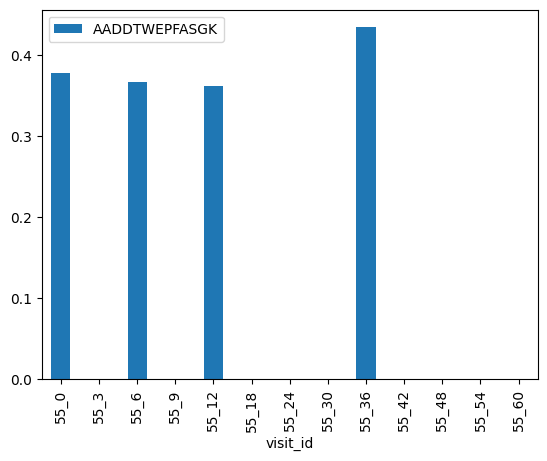

In [15]:
# We can see that some of the value are missing over the month.

visit_id_specific.plot(use_index=True, y="AADDTWEPFASGK", kind='bar')
plt.show()

In [ ]:
visit_id_specific.plot(use_index=True, y="AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K", kind='bar')
plt.show()

In [16]:
df1 = df.fillna(method="ffill")
df1

,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AANEVSSADVK,AATGEC(UniMod_4)TATVGKR,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
visit_id,,,,,,,,,,,,,,,,,,,,,
55_0,0,10.0,6.0,15.0,NaN,0.378517,0.200462,0.021986,NaN,0.016156,...,0.218140,0.150558,0.682349,0.027018,0.146764,0.011330,0.290456,0.091600,0.011818,0.026223
55_3,3,10.0,7.0,25.0,NaN,0.378517,0.200462,0.021986,NaN,0.016156,...,0.218140,0.150558,0.682349,0.027018,0.146764,0.011330,0.290456,0.091600,0.011818,0.026223
55_6,6,8.0,10.0,34.0,NaN,0.367787,0.179201,0.024904,1.0,0.022779,...,0.179524,0.124791,0.650899,0.028746,0.130530,0.010287,0.294590,0.081368,0.012196,0.034900
55_9,9,8.0,9.0,30.0,0.0,0.367787,0.179201,0.024904,1.0,0.022779,...,0.179524,0.124791,0.650899,0.028746,0.130530,0.010287,0.294590,0.081368,0.012196,0.034900
55_12,12,10.0,10.0,41.0,0.0,0.361881,0.177326,0.023456,1.0,0.013740,...,0.260621,0.158303,0.747632,0.028311,0.173299,0.012735,0.312116,0.075963,0.013082,0.037700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65043_48,48,7.0,6.0,13.0,0.0,0.374608,0.259382,0.027886,1.0,0.013325,...,0.227781,0.115953,0.684073,0.013892,0.142682,0.012314,0.275821,0.075535,0.012647,0.033099
65043_54,54,4.0,8.0,11.0,1.0,0.374608,0.259382,0.027886,1.0,0.013325,...,0.227781,0.115953,0.684073,0.013892,0.142682,0.012314,0.275821,0.075535,0.012647,0.033099
65043_60,60,6.0,6.0,16.0,1.0,0.374608,0.259382,0.027886,1.0,0.013325,...,0.227781,0.115953,0.684073,0.013892,0.142682,0.012314,0.275821,0.075535,0.012647,0.033099


Remark : I fill all the NaN value by the previous one and use it in the model as we will see later.

# Model and Neural Network

## Model: Mean absolute error

*The mean absolute error is one of a number of ways of comparing forecasts with their eventual outcomes.*

Starter

In [ ]:
def prepare_data(train_dataset, test_dataset, label):
    
    # Break into target and features
    train_dataset = train_dataset.dropna(subset=[label])
    test_dataset = test_dataset.dropna(subset=[label])

    # only the peptide percentage in the protein
    train_features = train_dataset.drop(target, axis=1).copy()
    test_features = test_dataset.drop(target, axis=1).copy()

    # only the updrs
    train_labels = train_dataset[label]
    test_labels = test_dataset[label]
    
    # Fill the Nan values by the mean value of the column
    for c in train_features.columns:
        m = train_features[c].mean()
        train_features[c] = train_features[c].fillna(m)

    for c in test_features.columns:
        m = test_features[c].mean()
        test_features[c] = test_features[c].fillna(m)
        
    return train_features, test_features, train_labels, test_labels

target = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]

train_dataset = df.sample(frac=0.7, random_state=0)
test_dataset = df.drop(train_dataset.index)

for label in target:

    train_features, test_features, train_labels, test_labels = prepare_data(train_dataset, test_dataset,label)
    train__features_val = train_features[-200:]
    train_labels_val = train_labels[-200:]
    
    # Normalization

    features = np.array(train_features)
    feat_normalizer = layers.Normalization(axis=-1)
    feat_normalizer.adapt(features)

    # Model
    model = tf.keras.Sequential([
        feat_normalizer,
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(484, activation='relu'),
        layers.Dense(242, activation='relu'),
        layers.Dense(121, activation='relu'),
        layers.Dense(60, activation='relu'),
        layers.Dense(units=1)
    ])

    # Training
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=10e-3),
        loss='mean_absolute_error',
        metrics="mean_absolute_error"
        )

    # Fitting
    history = model.fit(
        train_features,
        train_labels,
        batch_size=64,
        epochs=100,
        # Calculate validation results on 20% of the training data.
        validation_split = 0.2,
        )

    # Evaluate the model on the test data using `evaluate`
    print("Evaluate on test data")
    results = model.evaluate(test_features, test_labels, batch_size=128)
    print("test loss, test acc:", results)

    # Generate predictions (probabilities -- the output of the last layer)
    # on new data using `predict`
    print("Generate predictions for 3 samples")
    predictions = model.predict(test_features[:3])
    print("predictions shape:", predictions.shape
    )

    # summarize history for mean_absolute_percentage_error
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.title('model mean_absolute_percentage_error')
    plt.ylabel('mean_absolute_error')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

More layers

In [ ]:
def prepare_data(train_dataset, test_dataset, label):
    
    # Break into target and features
    train_dataset = train_dataset.dropna(subset=[label])
    test_dataset = test_dataset.dropna(subset=[label])

    # only the peptide percentage in the protein
    train_features = train_dataset.drop(target, axis=1).copy()
    test_features = test_dataset.drop(target, axis=1).copy()

    # only the updrs
    train_labels = train_dataset[label]
    test_labels = test_dataset[label]
    
    # Fill the Nan values by the mean value of the column
    for c in train_features.columns:
        m = train_features[c].mean()
        train_features[c] = train_features[c].fillna(m)

    for c in test_features.columns:
        m = test_features[c].mean()
        test_features[c] = test_features[c].fillna(m)
        
    return train_features, test_features, train_labels, test_labels

target = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]

train_dataset = df.sample(frac=0.7, random_state=0)
test_dataset = df.drop(train_dataset.index)

for label in target:

    train_features, test_features, train_labels, test_labels = prepare_data(train_dataset, test_dataset,label)
    train__features_val = train_features[-200:]
    train_labels_val = train_labels[-200:]
    
    # Normalization

    features = np.array(train_features)
    feat_normalizer = layers.Normalization(axis=-1)
    feat_normalizer.adapt(features)

    # Model
    model = tf.keras.Sequential([
        feat_normalizer,
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(484, activation='relu'),
        layers.Dense(242, activation='relu'),
        layers.Dense(121, activation='relu'),
        layers.Dense(60, activation='relu'),
        layers.Dense(units=1)
    ])

    # Training
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='mean_absolute_error',
        metrics="mean_absolute_error"
        )

    # Fitting
    history = model.fit(
        train_features,
        train_labels,
        batch_size=64,
        epochs=100,
        # Calculate validation results on 20% of the training data.
        validation_split = 0.2,
        )

    # Evaluate the model on the test data using `evaluate`
    print("Evaluate on test data")
    results = model.evaluate(test_features, test_labels, batch_size=128)
    print("test loss, test acc:", results)

    # Generate predictions (probabilities -- the output of the last layer)
    # on new data using `predict`
    print("Generate predictions for 3 samples")
    predictions = model.predict(test_features[:3])
    print("predictions shape:", predictions.shape
    )
    
    # summarize history for mean_absolute_percentage_error
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.title('model mean_absolute_error')
    plt.ylabel('mean_absolute_error')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Reduce the learning rate

In [ ]:
def prepare_data(train_dataset, test_dataset, label):
    
    # Break into target and features
    train_dataset = train_dataset.dropna(subset=[label])
    test_dataset = test_dataset.dropna(subset=[label])

    # only the peptide percentage in the protein
    train_features = train_dataset.drop(target, axis=1).copy()
    test_features = test_dataset.drop(target, axis=1).copy()

    # only the updrs
    train_labels = train_dataset[label]
    test_labels = test_dataset[label]
    
    # Fill the Nan values by the mean value of the column
    for c in train_features.columns:
        m = train_features[c].mean()
        train_features[c] = train_features[c].fillna(m)

    for c in test_features.columns:
        m = test_features[c].mean()
        test_features[c] = test_features[c].fillna(m)
        
    return train_features, test_features, train_labels, test_labels

target = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]

train_dataset = df.sample(frac=0.7, random_state=0)
test_dataset = df.drop(train_dataset.index)

for label in target:

    train_features, test_features, train_labels, test_labels = prepare_data(train_dataset, test_dataset,label)
    train__features_val = train_features[-200:]
    train_labels_val = train_labels[-200:]
    
    # Normalization

    features = np.array(train_features)
    feat_normalizer = layers.Normalization(axis=-1)
    feat_normalizer.adapt(features)

    # Model
    model = tf.keras.Sequential([
        feat_normalizer,
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(484, activation='relu'),
        layers.Dense(242, activation='relu'),
        layers.Dense(121, activation='relu'),
        layers.Dense(60, activation='relu'),
        layers.Dense(units=1)
    ])

    # Training
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='mean_absolute_error',
        metrics="mean_absolute_error"
        )

    # Fitting
    history = model.fit(
        train_features,
        train_labels,
        batch_size=64,
        epochs=100,
        # Calculate validation results on 20% of the training data.
        validation_split = 0.2,
        )

    # Evaluate the model on the test data using `evaluate`
    print("Evaluate on test data")
    results = model.evaluate(test_features, test_labels, batch_size=128)
    print("test loss, test acc:", results)

    # Generate predictions (probabilities -- the output of the last layer)
    # on new data using `predict`
    print("Generate predictions for 3 samples")
    predictions = model.predict(test_features[:3])
    print("predictions shape:", predictions.shape
    )
    
    # summarize history for mean_absolute_percentage_error
    plt.plot(history.history['mean_absolute_percentage_error'])
    plt.plot(history.history['val_mean_absolute_percentage_error'])
    plt.title('model mean_absolute_error')
    plt.ylabel('mean_absolute_error')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

50 % data train and 50 % data test

In [ ]:
def prepare_data(train_dataset, test_dataset, label):
    
    # Break into target and features
    train_dataset = train_dataset.dropna(subset=[label])
    test_dataset = test_dataset.dropna(subset=[label])

    # only the peptide percentage in the protein
    train_features = train_dataset.drop(target, axis=1).copy()
    test_features = test_dataset.drop(target, axis=1).copy()

    # only the updrs
    train_labels = train_dataset[label]
    test_labels = test_dataset[label]
    
    # Fill the Nan values by the mean value of the column
    for c in train_features.columns:
        m = train_features[c].mean()
        train_features[c] = train_features[c].fillna(m)

    for c in test_features.columns:
        m = test_features[c].mean()
        test_features[c] = test_features[c].fillna(m)
        
    return train_features, test_features, train_labels, test_labels

target = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]

train_dataset = df.sample(frac=0.5, random_state=0)
test_dataset = df.drop(train_dataset.index)

for label in target:

    train_features, test_features, train_labels, test_labels = prepare_data(train_dataset, test_dataset,label)
    train__features_val = train_features[-200:]
    train_labels_val = train_labels[-200:]
    
    # Normalization

    features = np.array(train_features)
    feat_normalizer = layers.Normalization(axis=-1)
    feat_normalizer.adapt(features)

    # Model
    model = tf.keras.Sequential([
        feat_normalizer,
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(484, activation='relu'),
        layers.Dense(242, activation='relu'),
        layers.Dense(121, activation='relu'),
        layers.Dense(60, activation='relu'),
        layers.Dense(units=1)
    ])

    # Training
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='mean_absolute_error',
        metrics="mean_absolute_percentage_error"
        )

    # Fitting
    history = model.fit(
        train_features,
        train_labels,
        batch_size=64,
        epochs=100,
        # Calculate validation results on 20% of the training data.
        validation_split = 0.2,
        )

    # Evaluate the model on the test data using `evaluate`
    print("Evaluate on test data")
    results = model.evaluate(test_features, test_labels, batch_size=128)
    print("test loss, test acc:", results)

    # Generate predictions (probabilities -- the output of the last layer)
    # on new data using `predict`
    print("Generate predictions for 3 samples")
    predictions = model.predict(test_features[:3])
    print("predictions shape:", predictions.shape
    )
    
    # summarize history for mean_absolute_percentage_error
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.title('model mean_absolute_error')
    plt.ylabel('mean_absolute_error')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Reduce again the learning rates

In [ ]:
def prepare_data(train_dataset, test_dataset, label):
    
    # Break into target and features
    train_dataset = train_dataset.dropna(subset=[label])
    test_dataset = test_dataset.dropna(subset=[label])

    # only the peptide percentage in the protein
    train_features = train_dataset.drop(target, axis=1).copy()
    test_features = test_dataset.drop(target, axis=1).copy()

    # only the updrs
    train_labels = train_dataset[label]
    test_labels = test_dataset[label]
    
    # Fill the Nan values by the mean value of the column
    for c in train_features.columns:
        m = train_features[c].mean()
        train_features[c] = train_features[c].fillna(m)

    for c in test_features.columns:
        m = test_features[c].mean()
        test_features[c] = test_features[c].fillna(m)
        
    return train_features, test_features, train_labels, test_labels

target = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]

train_dataset = df.sample(frac=0.5, random_state=0)
test_dataset = df.drop(train_dataset.index)

for label in target:

    train_features, test_features, train_labels, test_labels = prepare_data(train_dataset, test_dataset,label)
    train__features_val = train_features[-200:]
    train_labels_val = train_labels[-200:]
    
    # Normalization

    features = np.array(train_features)
    feat_normalizer = layers.Normalization(axis=-1)
    feat_normalizer.adapt(features)

    # Model
    model = tf.keras.Sequential([
        feat_normalizer,
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(484, activation='relu'),
        layers.Dense(242, activation='relu'),
        layers.Dense(121, activation='relu'),
        layers.Dense(60, activation='relu'),
        layers.Dense(units=1)
    ])

    # Training
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-8),
        loss='mean_absolute_error',
        metrics="mean_absolute_error"
        )

    # Fitting
    history = model.fit(
        train_features,
        train_labels,
        batch_size=64,
        epochs=100,
        # Calculate validation results on 20% of the training data.
        validation_split = 0.2,
        )

    # Evaluate the model on the test data using `evaluate`
    print("Evaluate on test data")
    results = model.evaluate(test_features, test_labels, batch_size=128)
    print("test loss, test acc:", results)

    # Generate predictions (probabilities -- the output of the last layer)
    # on new data using `predict`
    print("Generate predictions for 3 samples")
    predictions = model.predict(test_features[:3])
    print("predictions shape:", predictions.shape
    )
    
    # summarize history for mean_absolute_percentage_error
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.title('model mean_absolute_error')
    plt.ylabel('mean_absolute_error')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

*Clearly seems a good way to reach the zero loss and zero mean absolute error, however we need maybe 10 000 epochs. It takes a long time.*

Using the df1 dataframe

Epoch 1/1000
17/17 [==============================] - 4s 126ms/step - loss: 2.2983 - mean_absolute_error: 2.2983 - val_loss: 2.2930 - val_mean_absolute_error: 2.2930
Epoch 2/1000
17/17 [==============================] - 2s 112ms/step - loss: 2.2927 - mean_absolute_error: 2.2927 - val_loss: 2.2913 - val_mean_absolute_error: 2.2913
Epoch 3/1000
17/17 [==============================] - 2s 116ms/step - loss: 2.2916 - mean_absolute_error: 2.2916 - val_loss: 2.2908 - val_mean_absolute_error: 2.2908
Epoch 4/1000
17/17 [==============================] - 2s 113ms/step - loss: 2.2908 - mean_absolute_error: 2.2908 - val_loss: 2.2905 - val_mean_absolute_error: 2.2905
Epoch 5/1000
17/17 [==============================] - 2s 116ms/step - loss: 2.2901 - mean_absolute_error: 2.2901 - val_loss: 2.2903 - val_mean_absolute_error: 2.2903
Epoch 6/1000
17/17 [==============================] - 2s 120ms/step - loss: 2.2894 - mean_absolute_error: 2.2894 - val_loss: 2.2900 - val_mean_absolute_error: 2.2900
Epoc

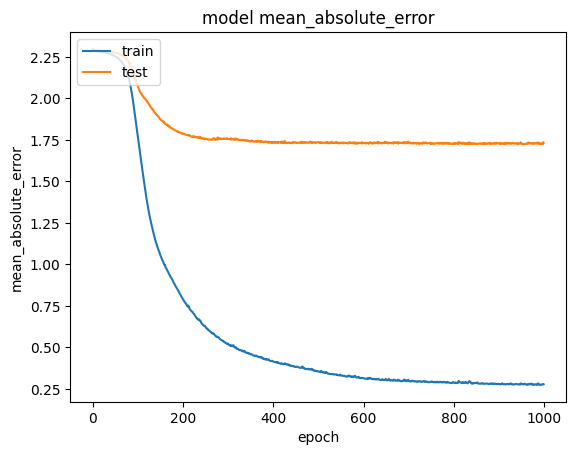

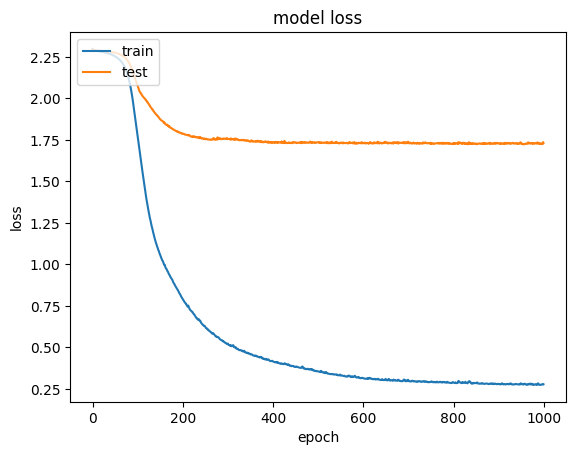

In [17]:
def prepare_data(train_dataset, test_dataset, label):
    
    # Break into target and features
    train_dataset = train_dataset.dropna(subset=[label])
    test_dataset = test_dataset.dropna(subset=[label])

    # only the peptide percentage in the protein
    train_features = train_dataset.drop(target, axis=1).copy()
    test_features = test_dataset.drop(target, axis=1).copy()

    # only the updrs
    train_labels = train_dataset[label]
    test_labels = test_dataset[label]
    
    # Fill the Nan values by the mean value of the column
    for c in train_features.columns:
        m = train_features[c].mean()
        train_features[c] = train_features[c].fillna(m)

    for c in test_features.columns:
        m = test_features[c].mean()
        test_features[c] = test_features[c].fillna(m)
        
    return train_features, test_features, train_labels, test_labels

# target = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]
target = ["updrs_4"]

train_dataset = df1.sample(frac=0.5, random_state=0)
test_dataset = df1.drop(train_dataset.index)

for label in target:

    train_features, test_features, train_labels, test_labels = prepare_data(train_dataset, test_dataset,label)
    train__features_val = train_features[-200:]
    train_labels_val = train_labels[-200:]
    
    # Normalization

    features = np.array(train_features)
    feat_normalizer = layers.Normalization(axis=-1)
    feat_normalizer.adapt(features)

    # Model
    model = tf.keras.Sequential([
        feat_normalizer,
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(969, activation='relu'),
        layers.Dense(484, activation='relu'),
        layers.Dense(242, activation='relu'),
        layers.Dense(121, activation='relu'),
        layers.Dense(60, activation='relu'),
        layers.Dense(units=1)
    ])

    # Training
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
        loss='mean_absolute_error',
        metrics="mean_absolute_error"
        )

    # Fitting
    history = model.fit(
        train_features,
        train_labels,
        batch_size=64,
        epochs=1000,
        # Calculate validation results on 20% of the training data.
        validation_split = 0.2,
        )

    # Evaluate the model on the test data using `evaluate`
    print("Evaluate on test data")
    results = model.evaluate(test_features, test_labels, batch_size=128)
    print("test loss, test acc:", results)

    # Generate predictions (probabilities -- the output of the last layer)
    # on new data using `predict`
    print("Generate predictions for 3 samples")
    predictions = model.predict(test_features[:3])
    print("predictions shape:", predictions.shape
    )
    
    # summarize history for mean_absolute_percentage_error
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.title('model mean_absolute_error')
    plt.ylabel('mean_absolute_error')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()